In [32]:
import os
from pathlib import Path
os.chdir(str(Path(os.getcwd()).parent.absolute()))
from datetime import date,datetime,timedelta

import cudf
import dask_cudf
import pandas as pd
import cupy
import cuml
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
import numpy as np

from src.metric.loss import symmetric_mean_absolute_percentage_error as smape

In [3]:
from tsfresh.feature_extraction import extract_features

In [4]:
df=pd.read_csv('data/train.csv')

In [5]:
df['first_day_of_month']=pd.to_datetime(df['first_day_of_month'])

In [6]:
features=['row_id','cfips','first_day_of_month','mcb','active']

In [7]:
df_=(
    df.rename(mapper={'microbusiness_density':'mcb'},axis=1)
    .sort_values('row_id')
    .assign(next_mcb=lambda x:x.groupby('cfips')['mcb'].shift(-1))
    .assign(target=lambda x:(x.next_mcb-x.mcb)/x.mcb)
)

In [8]:

features=['row_id', 'cfips', 'first_day_of_month', 'target','active']

In [9]:
df_label=df_[['row_id','target','first_day_of_month']].dropna()
df_label['target']=df_label['target'].clip(-.05,.05)

In [10]:
df_feature_1=df_[features].copy(deep=True).rename({'first_day_of_month':'dt1','target':'target_1'},axis=1)
df_feature_2=df_[features].copy(deep=True).rename({'first_day_of_month':'dt2','target':'target_2'},axis=1).drop(['active'],axis=1)

In [11]:
df_join=pd.merge(
    df_feature_1.drop(['row_id'],axis=1),
    df_feature_2,
    on='cfips'
).loc[lambda x:x.dt2>x.dt1].sort_values(['row_id','dt1'])[['row_id','target_1','dt1','active']].fillna(0)

In [12]:
df_join['target_1']=df_join['target_1'].clip(-.05,.05)

In [13]:
df_ts_feature=extract_features(df_join.drop(['active'],axis=1),column_id='row_id',column_sort='dt1')

Feature Extraction: 100%|██████████| 160/160 [02:44<00:00,  1.03s/it]


In [14]:
df_ft_active=df_join.groupby('row_id').agg(
    # last_active=('active',),
    # first_active=('active',pd.),
    mean_active=('active',np.mean),
    med_active=('active',np.median),
    max_active=('active',np.max),
    min_active=('active',np.min),
)
df_ft_active['last_active']=df_join.groupby('row_id')['active'].last()
df_ft_active['first_active']=df_join.groupby('row_id')['active'].first()
df_ft_active.reset_index(inplace=True)

In [15]:
df_ft_active

,row_id,mean_active,med_active,max_active,min_active,last_active,first_active
0,10001_2019-09-01,6624.000000,6624.0,6624,6624,6624,6624
1,10001_2019-10-01,6648.000000,6648.0,6672,6624,6672,6624
2,10001_2019-11-01,6685.333333,6672.0,6760,6624,6760,6624
3,10001_2019-12-01,6712.750000,6716.0,6795,6624,6795,6624
4,10001_2020-01-01,6719.000000,6744.0,6795,6624,6744,6624
...,...,...,...,...,...,...,...
119125,9015_2022-06-01,3496.882353,3461.5,3792,3266,3296,3440
119126,9015_2022-07-01,3491.085714,3440.0,3792,3266,3294,3440
119127,9015_2022-08-01,3486.972222,3414.0,3792,3266,3343,3440
119128,9015_2022-09-01,3482.540541,3388.0,3792,3266,3323,3440


In [16]:
df_final_feature=pd.merge(
    pd.merge(
        df_ft_active,
        df_ts_feature.reset_index(names='row_id'),
        on='row_id'
    ),
    df_label,
    on='row_id'
)

## Training

In [17]:
pivot_train=datetime(2022,1,1)

In [18]:
df_train=df_final_feature.loc[lambda x:x.first_day_of_month<pivot_train]

In [ ]:
df_eval=df_final_feature.loc[lambda x:x.first_day_of_month>pivot_train]


In [125]:
xgb=XGBRegressor(tree_method='gpu_hist', gpu_id=0,predictor='gpu_predictor',n_estimators=600,max_depth=64,max_leaves=2,learning_rate=.3)

In [126]:
xgb.fit(
    df_train.iloc[:int(0.7*len(df_train))].drop(['first_day_of_month','target','row_id'],axis=1),
    df_train.iloc[:int(0.7*(len(df_train)))]['target']
)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=64, max_leaves=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=0, ...)

In [127]:
mean_squared_error(
    df_train.iloc[int(0.7*(len(df_train))):]['target'],
    xgb.predict(df_train.iloc[int(0.7*(len(df_train))):].drop(['first_day_of_month','target','row_id'],axis=1).replace({np.inf:0,-np.inf:0}))
)

0.0003889028661403552

In [128]:
xgb.predict(df_train.iloc[int(0.7*(len(df_train))):].drop(['first_day_of_month','target','row_id'],axis=1).replace({np.inf:0,-np.inf:0}))


array([-0.00391972, -0.00313139,  0.00554517, ...,  0.00363034,
        0.00284216, -0.00049043], dtype=float32)

In [130]:
mean_squared_error(
    df_eval.iloc[:]['target'],
    xgb.predict(df_eval.iloc[:].drop(['first_day_of_month','target','row_id'],axis=1).replace({np.inf:0,-np.inf:0}))
)

0.0003116186775949489

In [131]:
df_eval_in_time=df_eval[['row_id','first_day_of_month','target']]
df_eval_in_time['pred']=xgb.predict(df_eval.iloc[:].drop(['first_day_of_month','target','row_id'],axis=1).replace({np.inf:0,-np.inf:0})).tolist()


/tmp/ipykernel_2287823/3217451328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval_in_time['pred']=xgb.predict(df_eval.iloc[:].drop(['first_day_of_month','target','row_id'],axis=1).replace({np.inf:0,-np.inf:0})).tolist()


<Axes: >

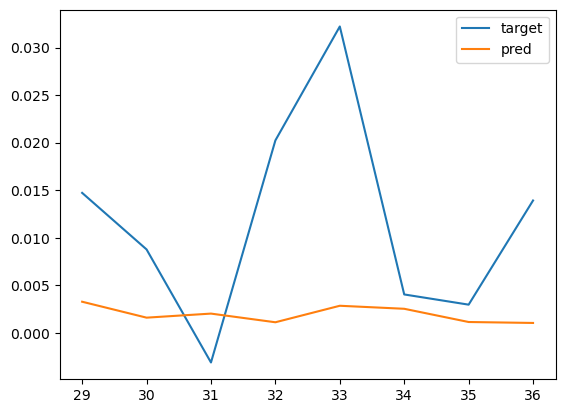

In [132]:
cfips=10001
df_eval_in_time.assign(cfips=lambda x:x.row_id.str.split('_').str[0].apply(int)).query('cfips==@cfips')\
    .sort_values('first_day_of_month')[['target','pred']].plot()